GJ4102: G140L spectra redone by STScI, G140M specta need re-exracting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from matplotlib.gridspec import GridSpec


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [10]:
path = '/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/'
stsci_path = '{}16701_07/data/'.format(path) #some data was redone by stsci.
st_x1ds = glob.glob('{}*x1d.fits'.format(stsci_path))
st_x1ds

['/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/16701_07/data/oeoo07010_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/16701_07/data/oeoo07020_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/16701_07/data/oeoo07030_x1d.fits']

/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/16701_07/data/oeoo07010_x1d.fits
G140L
82.32629


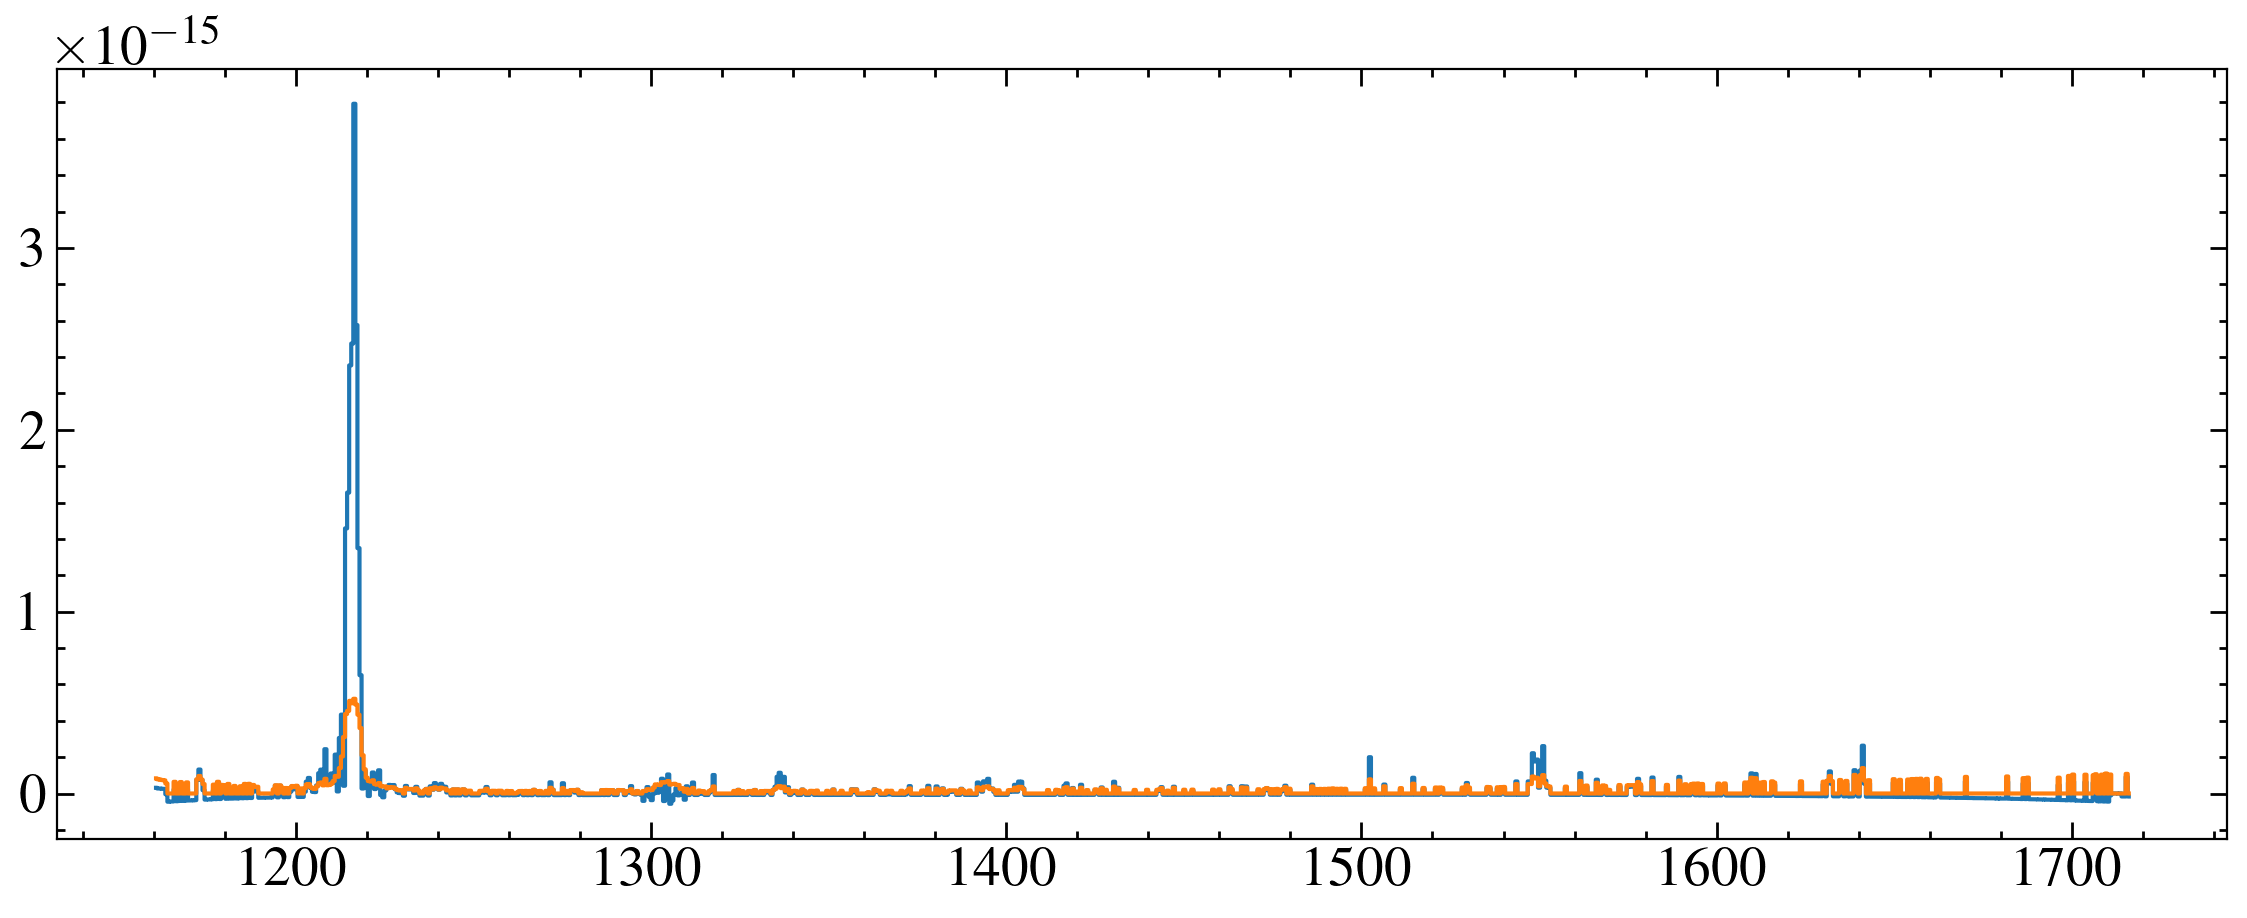

/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/16701_07/data/oeoo07020_x1d.fits
G140L
82.42636


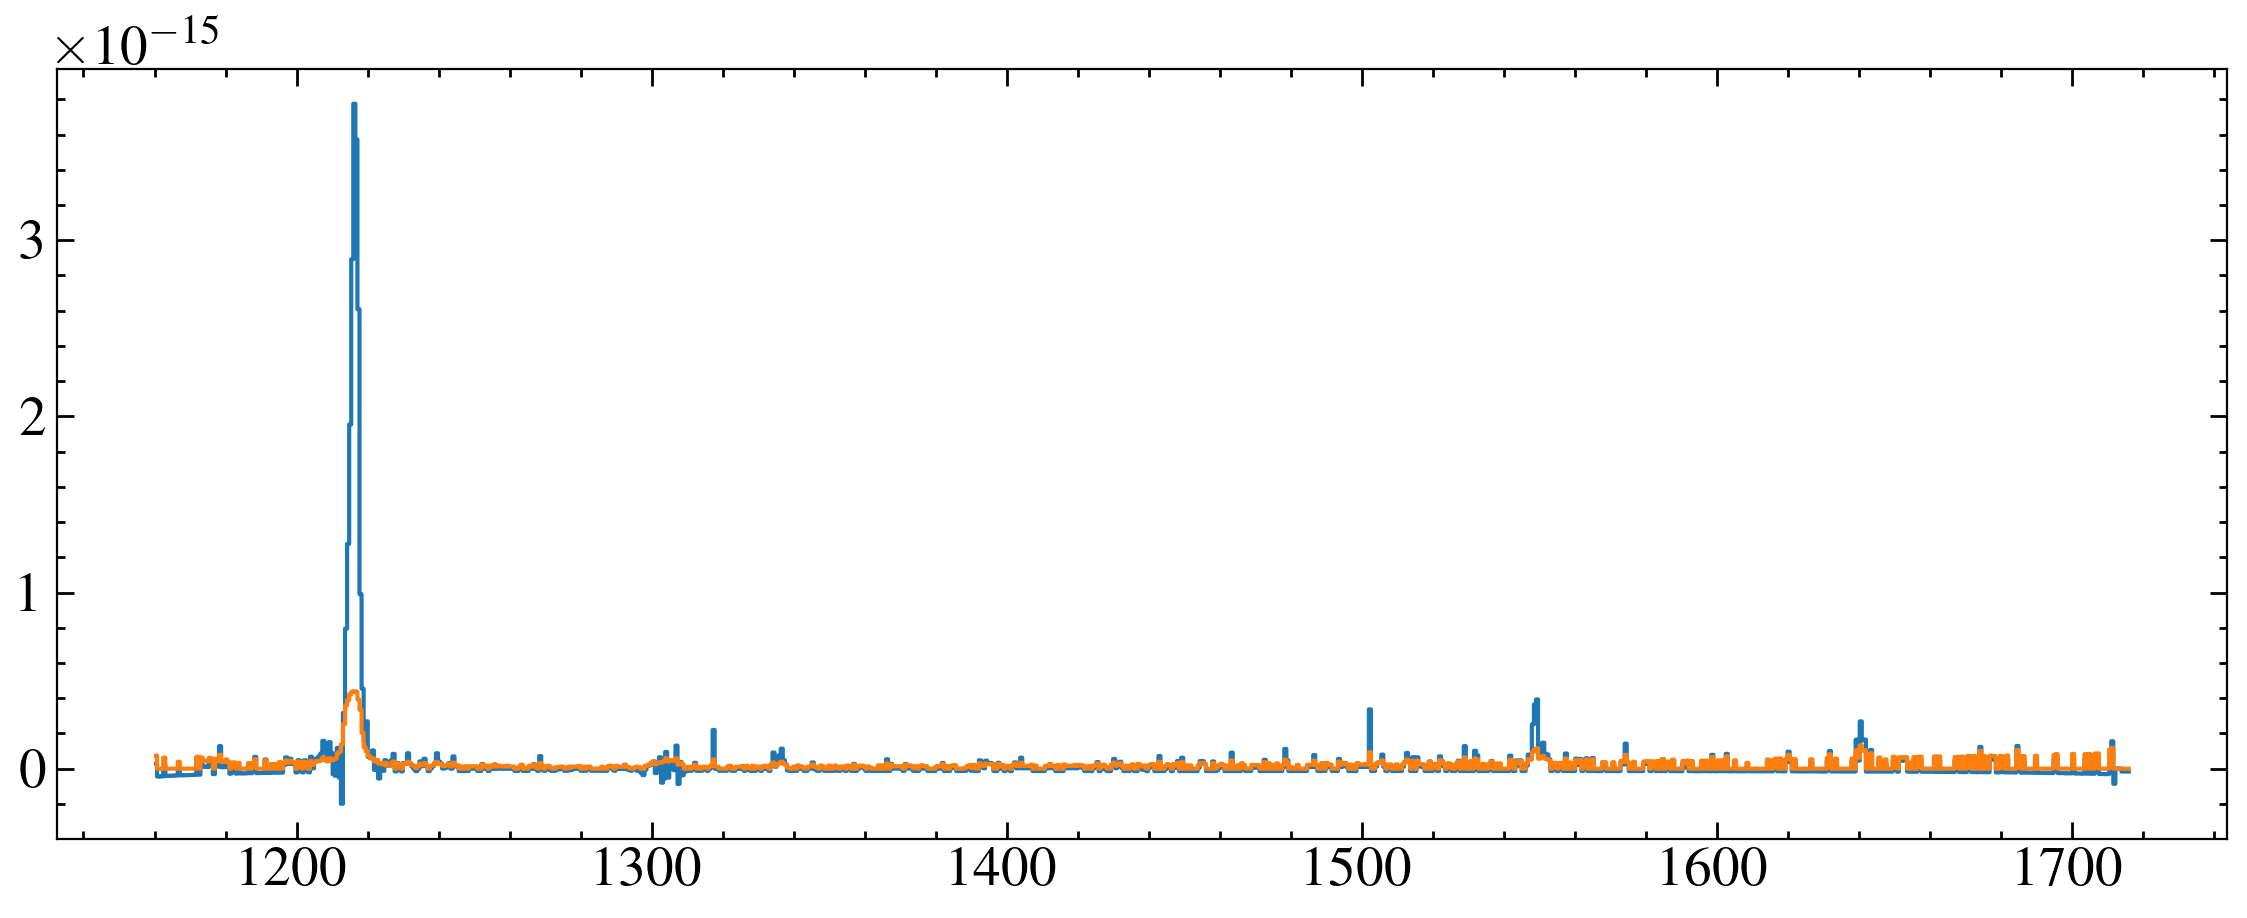

/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/16701_07/data/oeoo07030_x1d.fits
G140L
83.107735


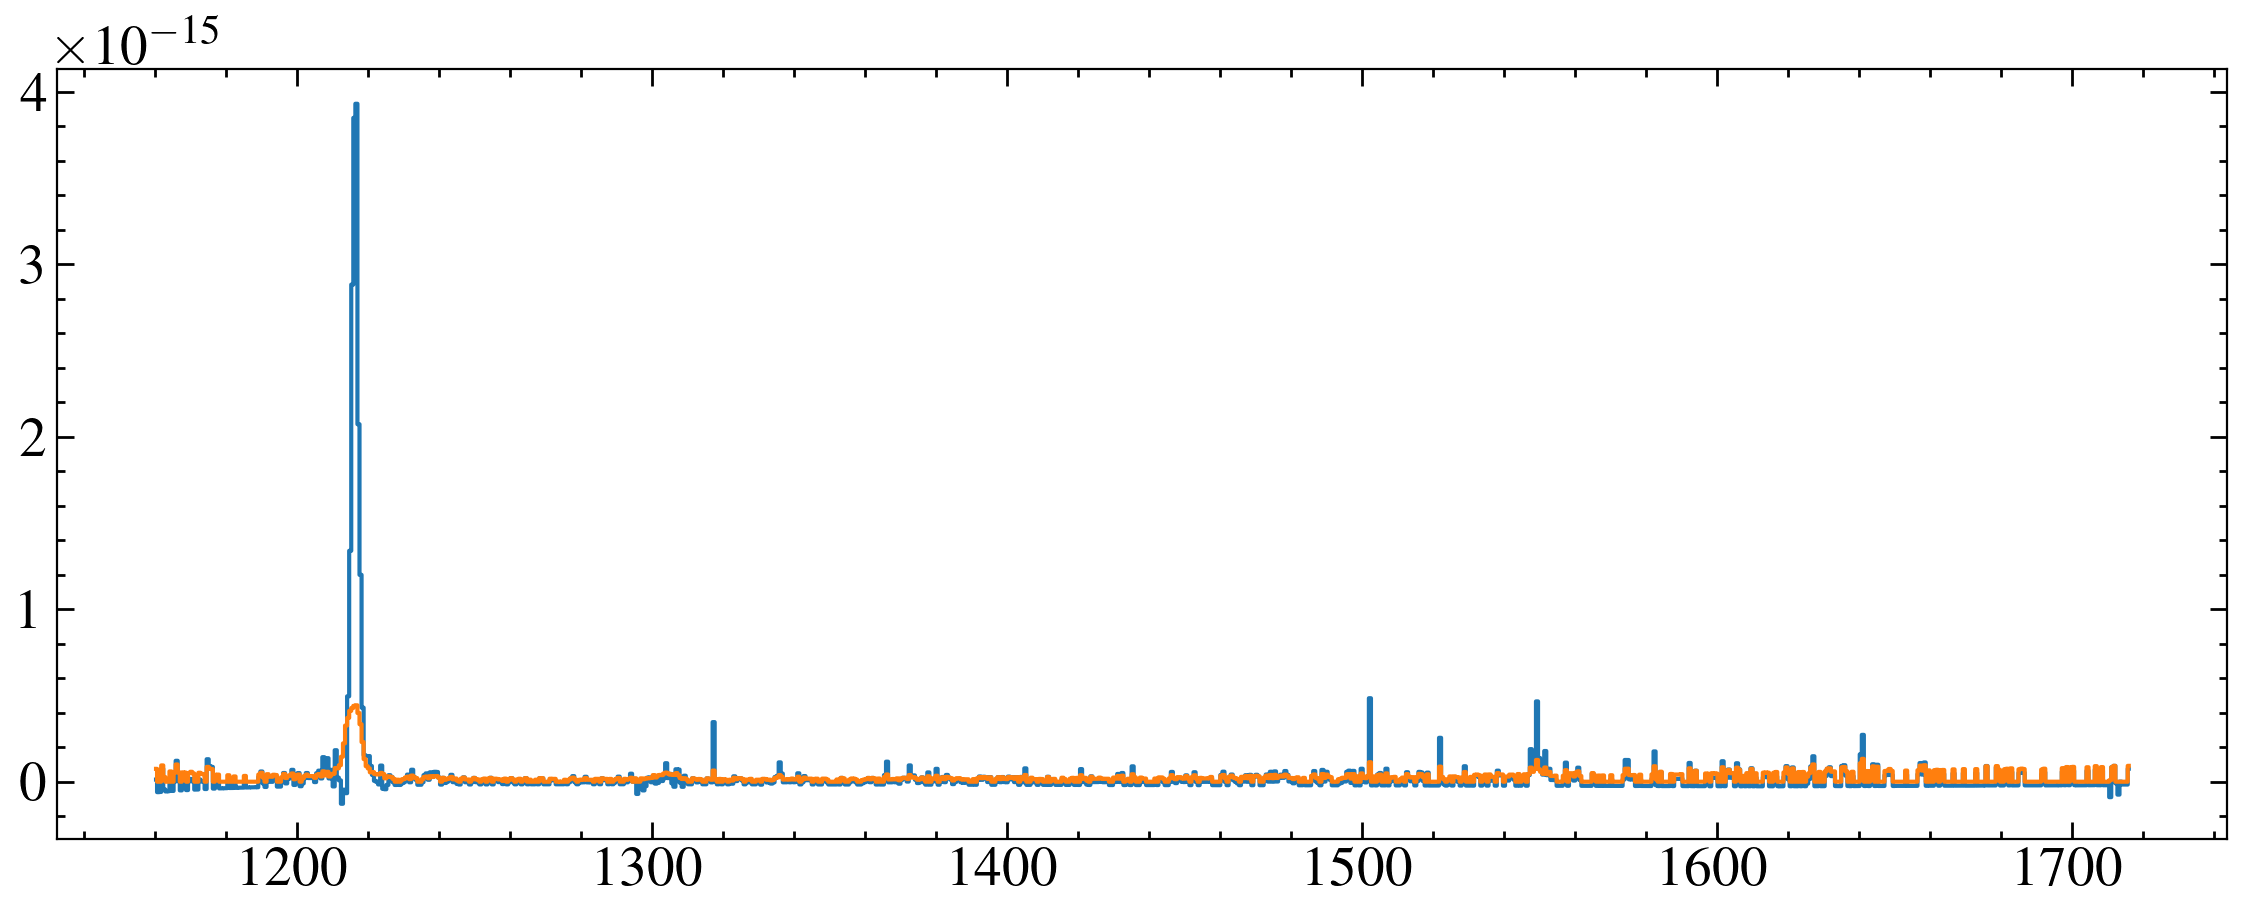

In [11]:
for x in st_x1ds:
    print(x)
    grating = fits.getheader(x, 0)['OPT_ELEM'] 
    print(grating)
    data = fits.getdata(x, 1)[0]
    print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    if grating in ['G140M', 'G140L']:
        mask = (w > 1160)
        
        # plt.ylim(-1e-16, 1e-16)
        # plt.axhline(0, ls='--', c='0.5')
    # if grating =='G230L':
    #     mask = (w > 1700)
    # if grating =='G430L':
    #     mask = (w > 3000)
    
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid')
    plt.step(w, e, where='mid')
    plt.show()
    

In [12]:
import stistools
os.environ['oref'] = path

In [13]:
def build_trace_grid(SPTRCTAB, grating, cenwave):
    """
    Extends a grid of trace displacements to cover all y positions
    """
    data = fits.getdata(SPTRCTAB, 1)
    tracedata = data[(data['OPT_ELEM']==grating) & (data['CENWAVE'] == cenwave)]
    all_y = np.arange(len(tracedata[0]['A2DISPL']))
    grid = interp1d(tracedata['A2CENTER'], tracedata['A2DISPL'], axis=0, fill_value='extrapolate')(all_y)
    tracegrid = [a+b for a, b in zip(grid, all_y)] 
    return tracegrid
    
def get_a2center(x, y, tracegrid):
    """
    get the trace a2center at a1center
    """
    xcol = np.array(tracegrid)[:,int(x)]
    xind = (np.abs(xcol - y)).argmin()
    a2center = xind + 1 #calstis is 1-indexed 
    return a2center

In [14]:
roots = ['oeoo08010', 'oeoo08020', 'oeoo08030']


oeoo08010
159
oeoo08020
159
oeoo08030
160
reextractions/gj4102/oeoo08020_new_x1d.fits
G140M
159.89096


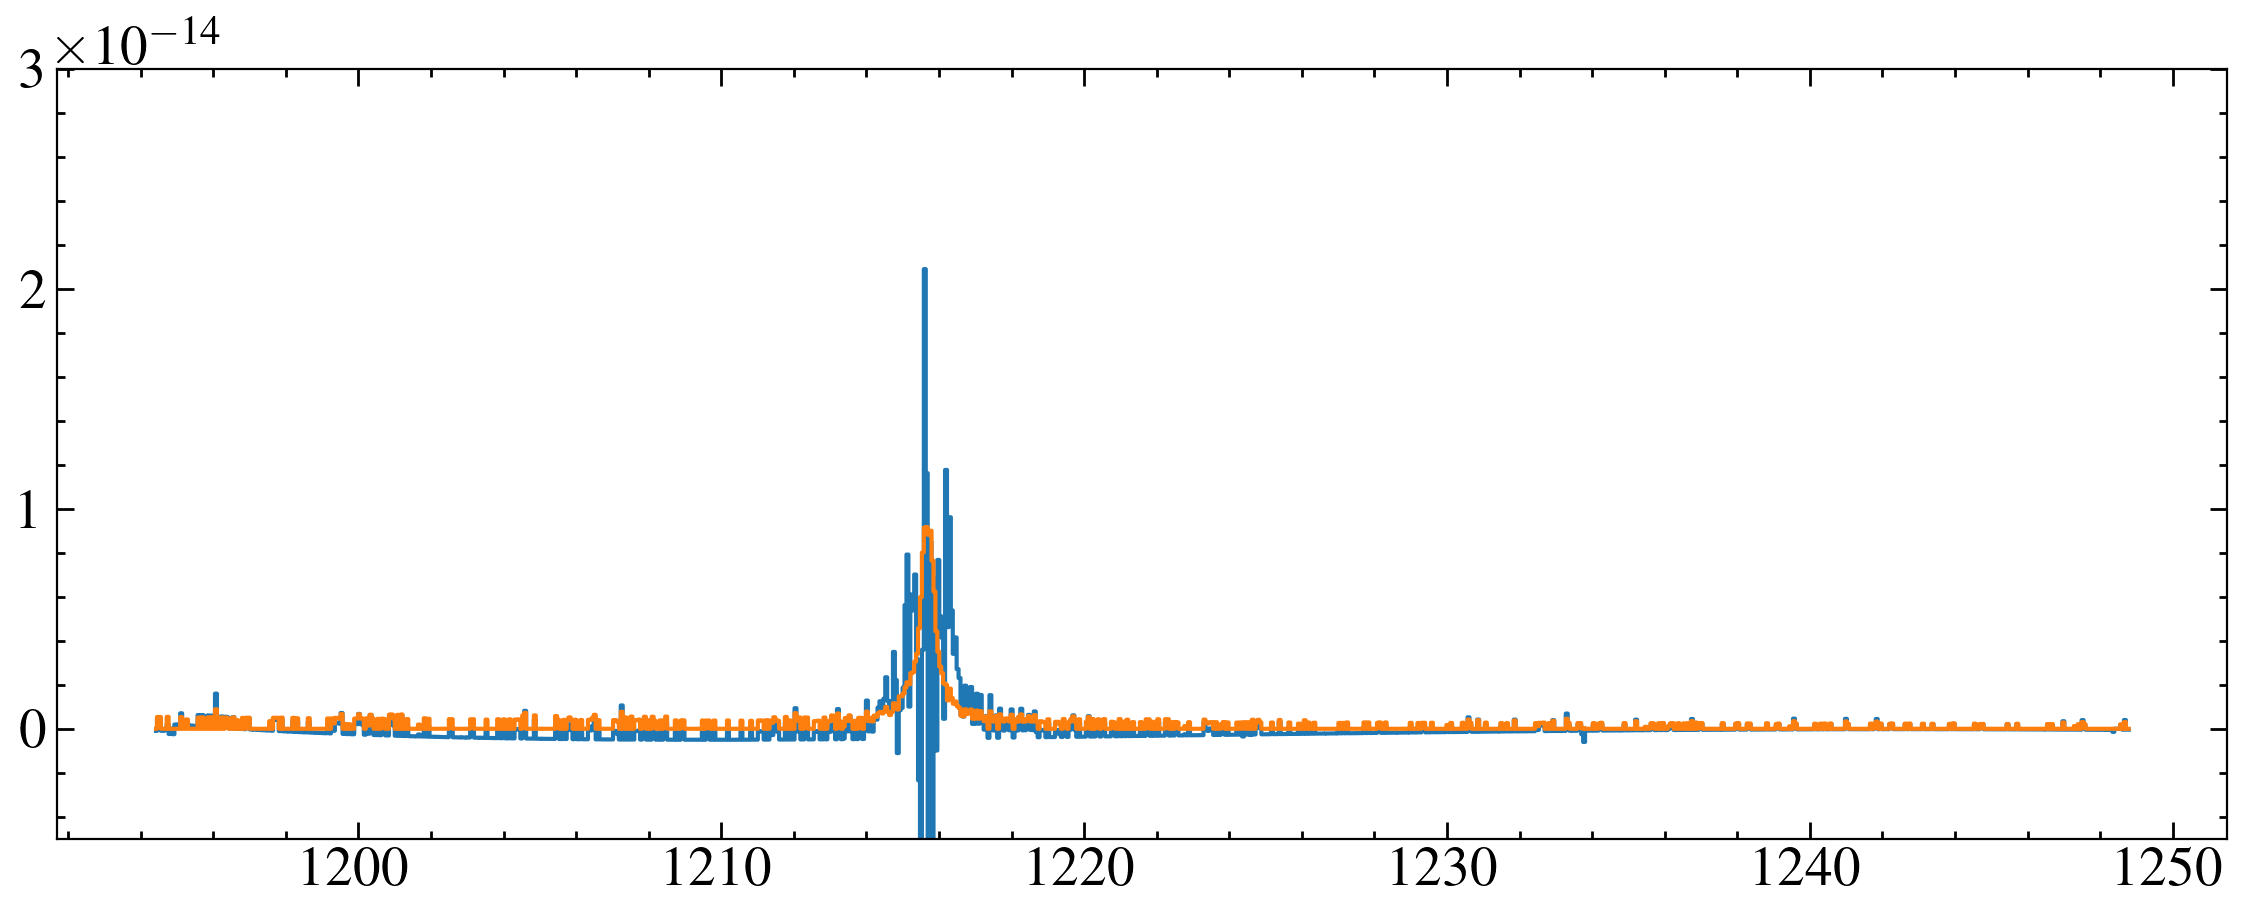

reextractions/gj4102/oeoo08030_new_x1d.fits
G140M
159.94882


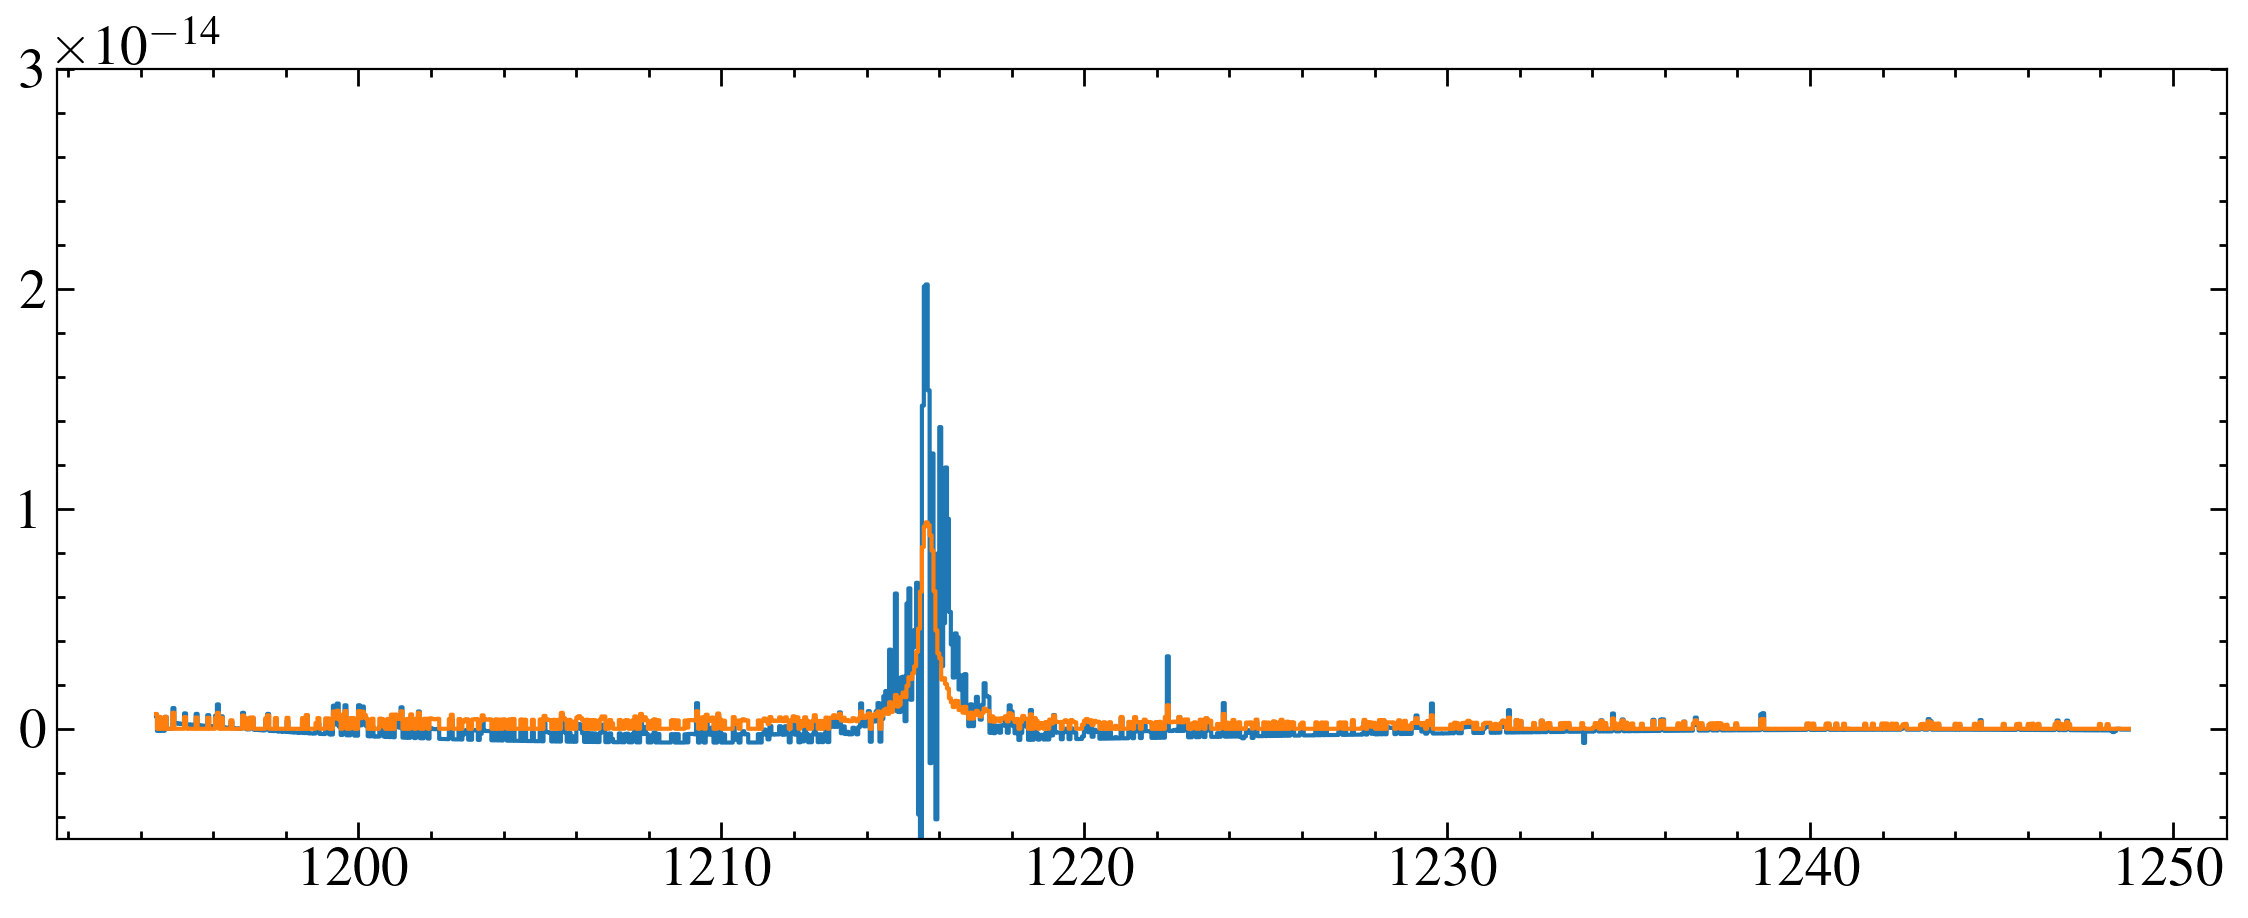

reextractions/gj4102/oeoo08010_new_x1d.fits
G140M
156.99675


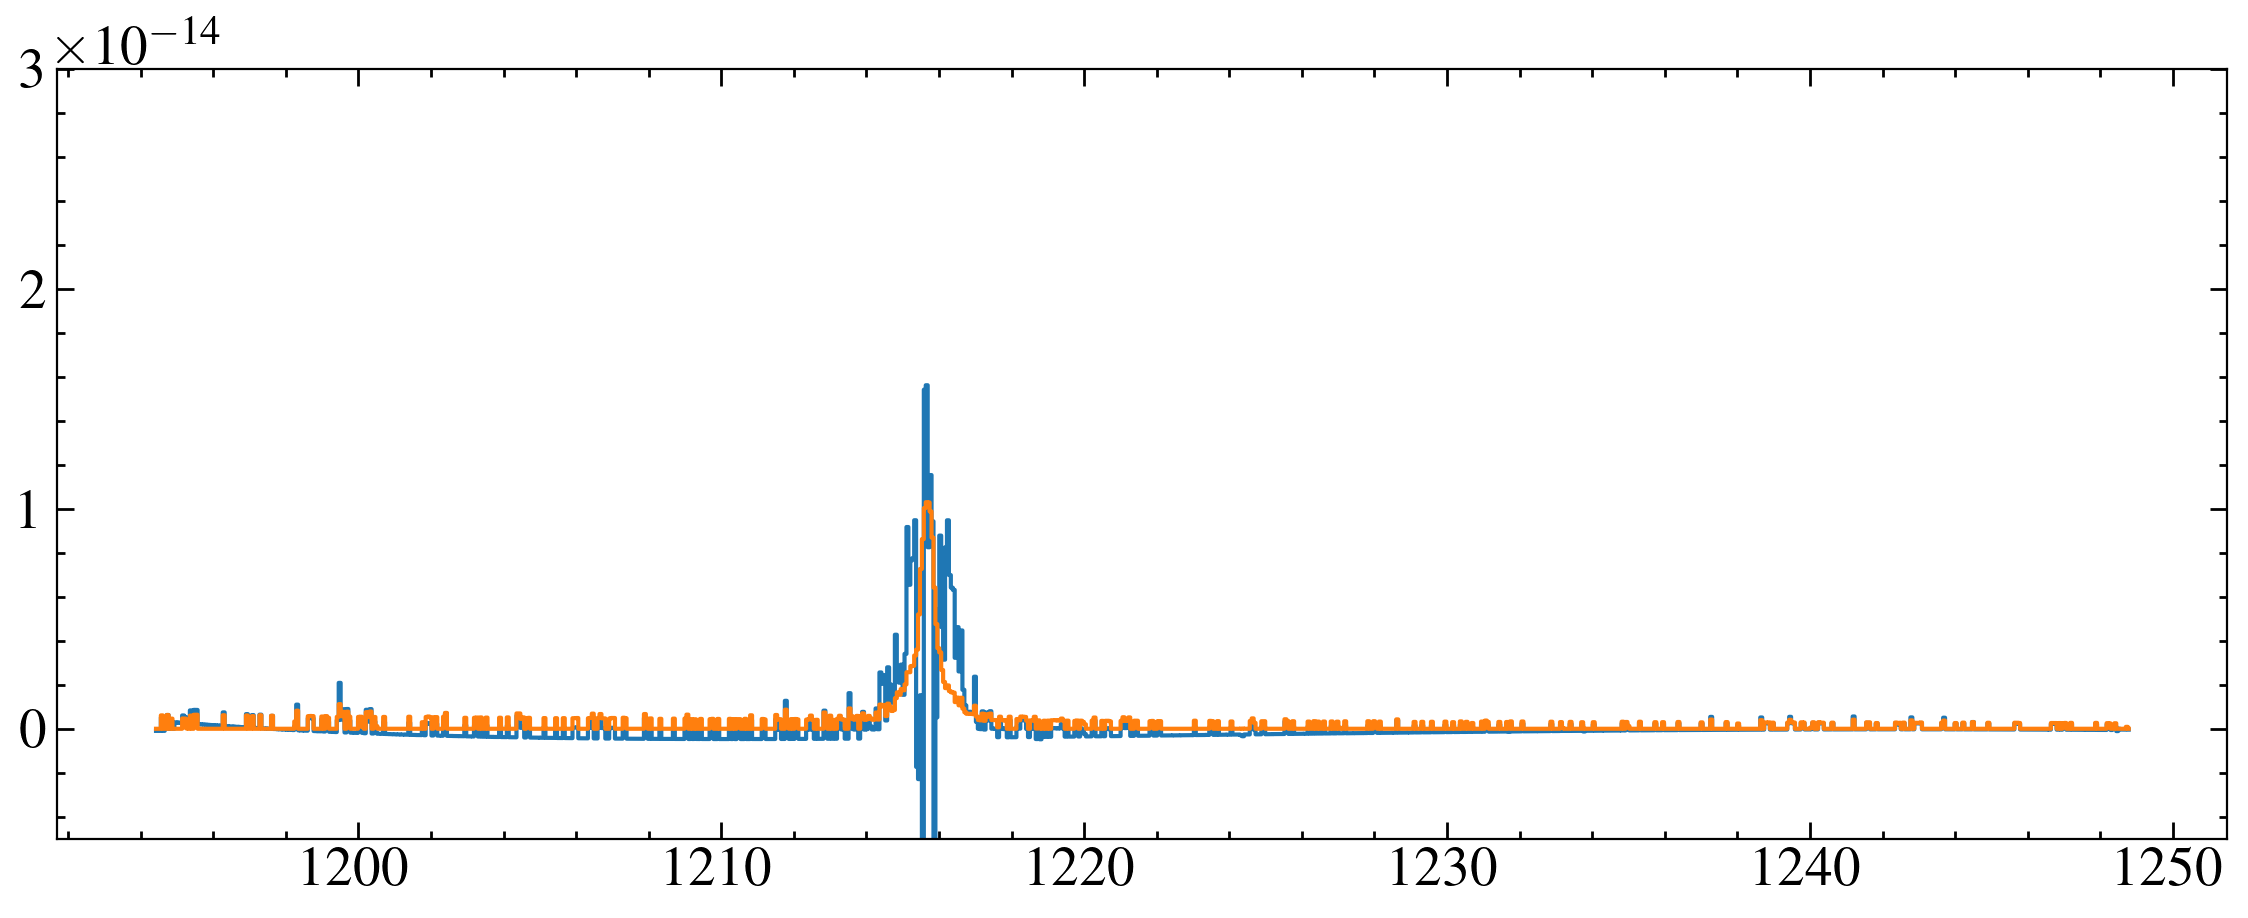

In [77]:
xs = [405, 408, 410]
ys = [157, 157, 158]

for i, root in  enumerate(roots):
    flt = '{}/{}_flt.fits'.format(path, root)
    SPTRCTAB = fits.getheader(flt,0)['SPTRCTAB']
    grating = fits.getheader(flt,0)['OPT_ELEM']
    cenwave = fits.getheader(flt,0)['CENWAVE']
    tracegrid = build_trace_grid(path+SPTRCTAB[5:], grating, cenwave)
    rootname = fits.getheader(flt)['ROOTNAME'] 
    outname = 'reextractions/gj4102/{}_new_x1d.fits'.format(rootname)
    if os.path.exists(outname):
        os.remove(outname)
    a2center = get_a2center(xs[i],ys[i], tracegrid)
    print(root)
    print(a2center)
    # a2center = 375
    stistools.x1d.x1d(flt, output = outname, trailer='reextractions/gj4102/{}_new.trl'.format(rootname), a2center=a2center,
                      maxsrch=5, bk1offst=-30, bk2offst=30,
                      bk1size=5, bk2size=5)
    # print(fits.getdata('reextractions/gj4102/{}_new_x1d.fits'.format(rootname),1)['A2CENTER'])
    
new_x1ds = glob.glob('reextractions/gj4102/*new_x1d.fits')
for x in new_x1ds:
    print(x)
    grating = fits.getheader(x, 0)['OPT_ELEM'] 
    print(grating)
    data = fits.getdata(x, 1)[0]
    print(data['A2Center'])
    w, f, e, dq= data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['DQ']
    if grating in ['G140M', 'G140L']:
        mask = (w > 1160) #& (w < 1210) | (w > 1220)

    
    w, f, e = w[mask], f[mask], e[mask]

    plt.step(w, f, where='mid')
    plt.step(w, e, where='mid')
    plt.ylim(-0.5e-14,3e-14 )
    plt.show()
    


In [78]:
new_x1ds = glob.glob('reextractions/gj4102/*new_x1d.fits')
new_x1ds

['reextractions/gj4102/oeoo08020_new_x1d.fits',
 'reextractions/gj4102/oeoo08030_new_x1d.fits',
 'reextractions/gj4102/oeoo08010_new_x1d.fits']

In [79]:
def spectra_adder(f_array, e_array, scale_correct=True):
    """
    Returns a variance-weighted coadd with standard error of the weighted mean (variance weights, scale corrected).
    f_array and e_arrays are collections of flux and error arrays, which should have the same lenth and wavelength scale
    """
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum((((flux - f_array)**2) * weights), axis=0) / (len(f_array)-1) #reduced chi-squared
    if scale_correct:
        error = (var * rcs)**0.5
    else:
        error = var**0.5
    return flux,error

In [80]:
x1ds = np.hstack((new_x1ds, st_x1ds))
x1ds

array(['reextractions/gj4102/oeoo08020_new_x1d.fits',
       'reextractions/gj4102/oeoo08030_new_x1d.fits',
       'reextractions/gj4102/oeoo08010_new_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/16701_07/data/oeoo07010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/16701_07/data/oeoo07020_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/gj4102/16701_07/data/oeoo07030_x1d.fits'],
      dtype='<U80')

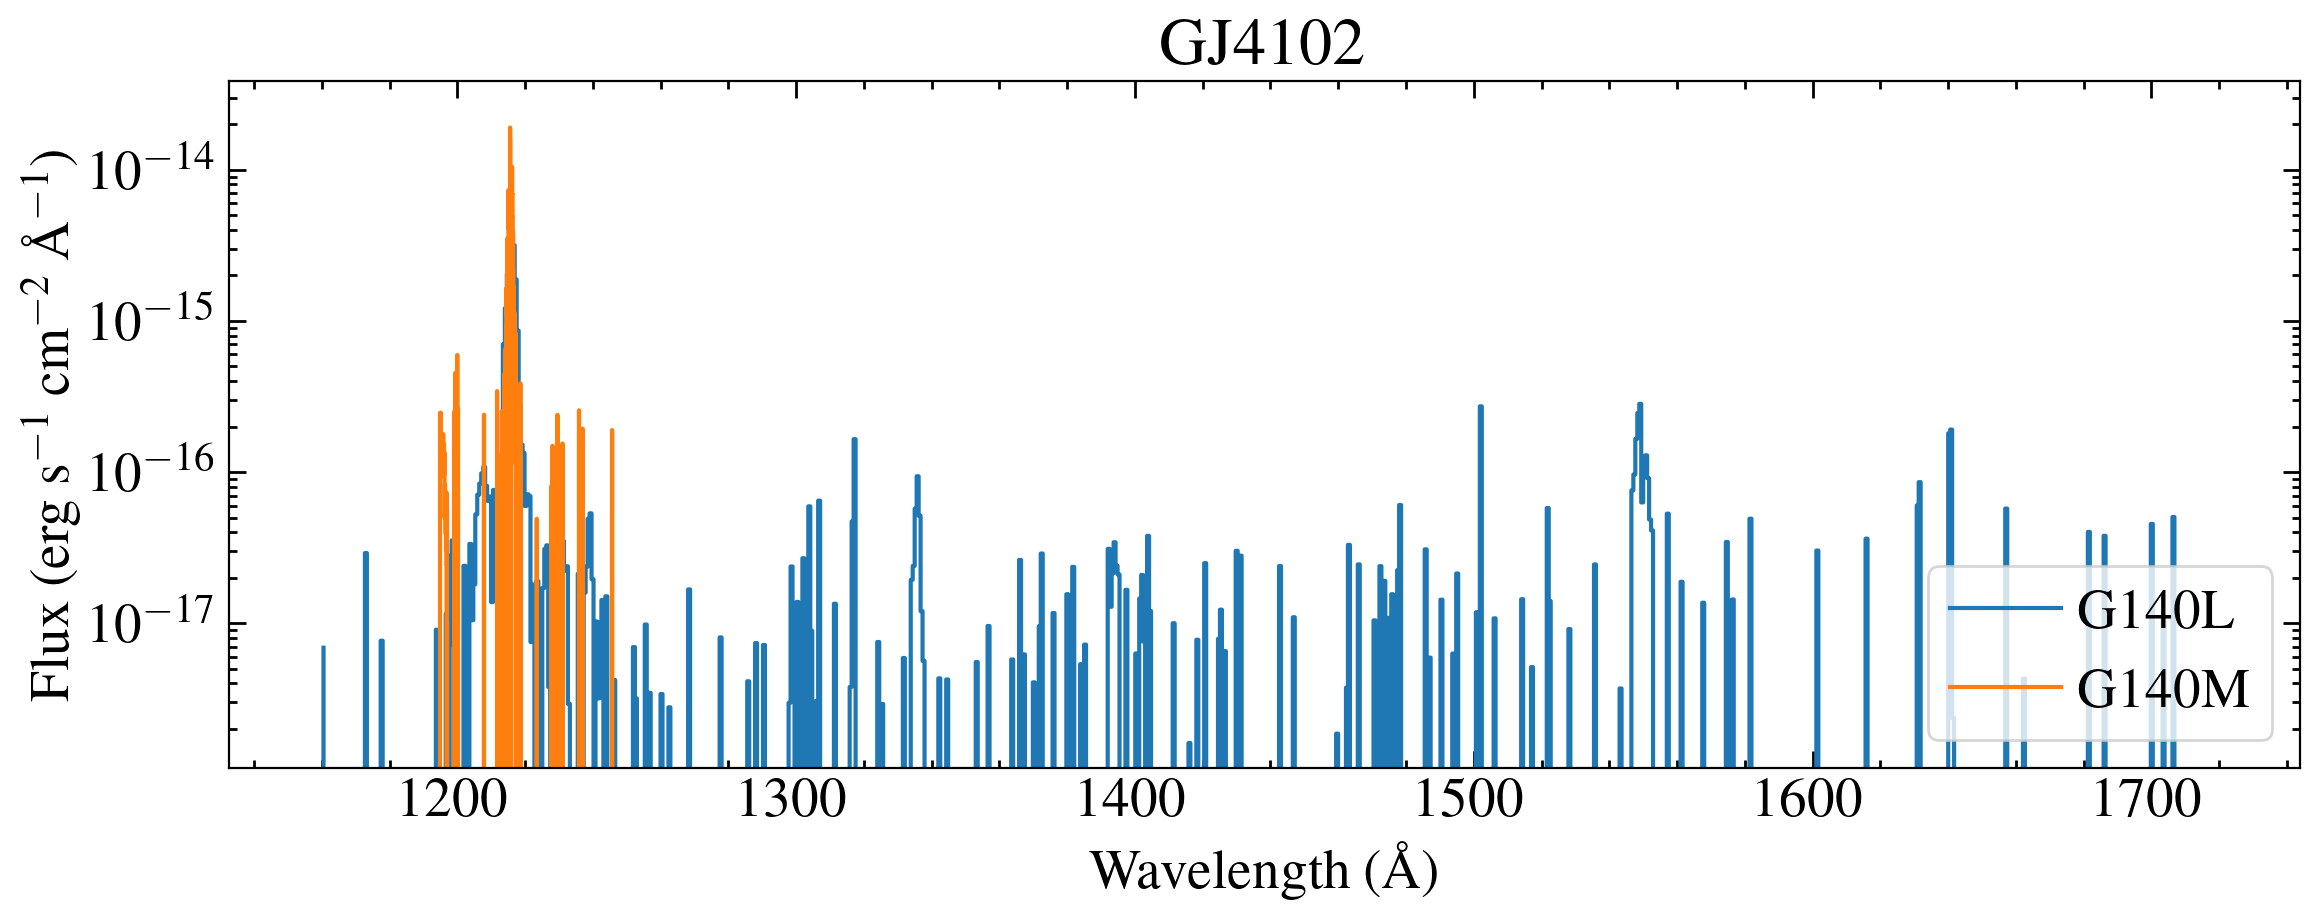

In [81]:


plt.figure(figsize=(12, 5))

f_nuv = []
e_nuv = []
f_fuv = []
e_fuv = []
f_lya = []
e_lya = []

n=0
o=0
p=0
for x in x1ds:
    data = fits.getdata(x, 1)[0]
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    grating = fits.getheader(x, 0)['OPT_ELEM']
    if grating == 'G230L':
        mask = (w > 1800) & (w <3130)
        w, f, e = w[mask], f[mask], e[mask]
        if n == 0:
            w_nuv = w
            f_nuv.append(f)
            e_nuv.append(e)
        else:
            f_nuv.append(interp1d(w, f, fill_value='extrapolate')(w_nuv))
            e_nuv.append(interp1d(w, e, fill_value='extrapolate')(w_nuv))            
        n +=1
    if grating == 'G140L':
        mask = (w > 1160)# & (w <1700)
        w, f, e = w[mask], f[mask], e[mask]
        if o == 0:
            w_fuv = w
            f_fuv.append(f)
            e_fuv.append(e)
        else:
            f_fuv.append(interp1d(w, f, fill_value='extrapolate')(w_fuv))
            e_fuv.append(interp1d(w, e, fill_value='extrapolate')(w_fuv))            
        o +=1
    if grating == 'G140M':
        # mask = (w > 1160) & (w <1700)
        # w, f, e = w[mask], f[mask], e[mask]
        if p == 0:
            w_lya = w
            f_lya.append(f)
            e_lya.append(e)
        else:
            f_lya.append(interp1d(w, f, fill_value='extrapolate')(w_lya))
            e_lya.append(interp1d(w, e, fill_value='extrapolate')(w_lya))            
        p +=1
    if grating == 'G430L':
        mask = (w > 3050) & (w <5520)
        w_opt, f_opt, e_opt = w[mask], f[mask], e[mask]
        
# f_nuv, e_nuv = spectra_adder(np.array(f_nuv), np.array(e_nuv), scale_correct=True)
f_fuv, e_fuv = spectra_adder(np.array(f_fuv), np.array(e_fuv), scale_correct=True)
f_lya, e_lya = spectra_adder(np.array(f_lya), np.array(e_lya), scale_correct=True)

plt.step(w_fuv, f_fuv, label='G140L')
# plt.step(w_nuv, f_nuv, label='G230L')
plt.step(w_lya, f_lya, label='G140M')
# plt.step(w_opt, f_opt, label='G430L', zorder=-1)

plt.yscale('log')
# plt.xscale('log')
plt.ylim(1.1e-18)
# plt.xlim(1060, 5520)
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.legend(frameon=True, loc=4)
plt.title('GJ4102')
plt.tight_layout()

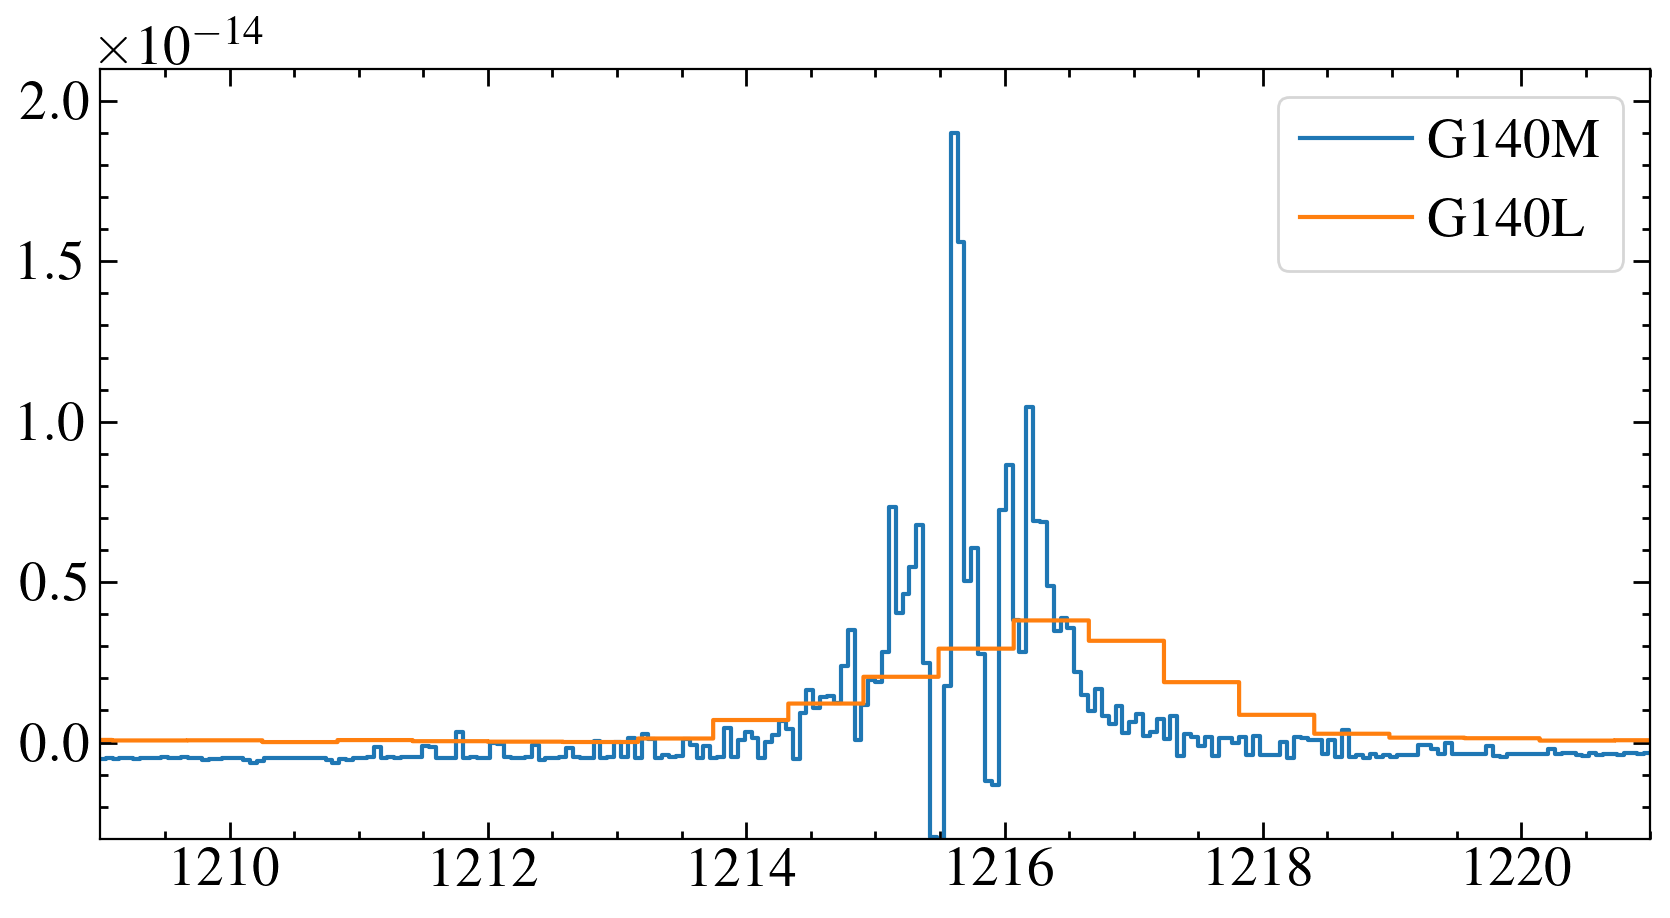

In [82]:
fig, ax=plt.subplots(figsize=(10,5))

plt.step(w_lya, f_lya, label='G140M',where='mid')

plt.step(w_fuv, f_fuv, label='G140L', where='mid')

plt.xlim(1209, 1221)
plt.ylim(-0.3e-14, 2.1e-14)
ax.legend(frameon=True)